In [154]:
import yfinance as yf
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [155]:
class Efficient_Frontier_Monte_Carlo:
    
    def __init__(self, assets, market, period):
        self.assets = assets
        self.period = period
        self.market = market
        self.data = yf.download(assets, period=period)['Adj Close']
        self.risk_free_rate = yf.download(market, period=period)['Adj Close'].pct_change().mean() * 252
        self.risk_free_rate = float(self.risk_free_rate.iloc[0])
        self.daily_returns = self.data.pct_change()
        self.mean_returns = self.daily_returns.mean()[-504:]
        self.cov_matrix = self.daily_returns.cov() 
        self.corr_matrix = self.daily_returns.corr() 
        self.n = len(self.assets)
        self.df = self.fill_df()
        self.min_volatility_index = self.df['Portfolio_Volatility'].idxmin()
        self.max_sharpe_index = self.df['Sharpe_Ratio'].idxmax()
        self.df2 = self.frontier()

    def monte_carlo(self):
        
        num_portfolios = 5_000_000 

        portfolio_volatility = []
        portfolio_returns = []
        portfolio_weights = []

        for i in range(num_portfolios):
            weights = np.random.rand(self.n)
            weights = weights/sum(weights)
            portfolio_weights.append(weights)
            portfolio_volatility.append(np.sqrt(np.dot(np.array(weights).T, np.dot(self.cov_matrix, weights)))*np.sqrt(252))
            portfolio_returns.append(np.sum(self.mean_returns * weights) * 252)

        return portfolio_weights, portfolio_returns, portfolio_volatility

    def fill_df(self):
        df = pd.DataFrame()
        weights, returns, volatility = self.monte_carlo()
        weights = list(np.around(np.array(weights), 4))
        df['Portfolio_Returns'] = list(np.around(np.array(returns), 4))
        df['Portfolio_Volatility'] = list(np.around(np.array(volatility), 4))
        df['Sharpe_Ratio'] = (np.array(returns) - self.risk_free_rate)/np.array(volatility)

        weight_cols = [asset + ' Weight' for asset in self.assets]
        np_weights = np.array(weights)

        for i in range(self.n):
            df[weight_cols[i]] = np_weights[:, i]
            
        return df 
    
    def frontier(self):
        group = (self.df.round(2)).groupby('Portfolio_Volatility')
        df2 = group.apply(lambda x: x['Portfolio_Returns'].max())
        return df2


    def output(self):
        # PRINT OPTIMAL PORTFOLIO WEIGHTS
        print ("OPTIMAL PORTFOLIO:")
        opt_weights = (self.df.iloc[self.max_sharpe_index])
        print(opt_weights)
        opt_weights.to_csv(r'Efficient_Frontier_Yaw_Amankwah\optimal_weights.csv', index_label='Portfolio#',index=True, header=True)

         # PRINT CORRELATION MATRIX
        sns.heatmap(self.corr_matrix, annot=True)
        plt.title("Correlation Matrix")
        plt.savefig("Correlation_Matrix.pdf")

         # PRINT EFFICIENT FRONTIER
        plt.figure(figsize=(16, 9))
        plt.scatter(x=self.df['Portfolio_Volatility'],y=self.df['Portfolio_Returns'],c=self.df['Sharpe_Ratio'], cmap='viridis', marker='o', s=10, alpha=0.3)
        plt.colorbar(label='Sharpe Ratio')

        # PRINT FRONTIER
        plt.plot(self.df2)

        # Mark the portfolio w/ max Sharpe ratio
        plt.scatter(self.df.iloc[self.min_volatility_index]['Portfolio_Volatility'], self.df.iloc[self.min_volatility_index]['Portfolio_Returns'], color ='r', marker='*', s=100, label='Minimum Volatility')
        plt.scatter(self.df.iloc[self.max_sharpe_index]['Portfolio_Volatility'], self.df.iloc[self.max_sharpe_index]['Portfolio_Returns'], color ='g', marker='*', s=100, label = 'Max Sharpe Ratio')
        plt.title(' Efficient Frontier')
        plt.xlabel('Annualized Volatility')
        plt.ylabel('Annualized Returns')
        plt.legend(labelspacing=1.2)
        plt.savefig("Efficient_Frontier.jpg")
        plt.show()


In [156]:
assets = ['CNP', 'F', 'WMT', 'GE', 'AAPL', 'TSLA', 'QCOM']


In [157]:
market = ['SPY']
period = '10y'
eff_front = Efficient_Frontier_Monte_Carlo(sorted(assets), market, period)

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9082/1183469726.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = group.apply(lambda x: x['Portfolio_Returns'].max())


OPTIMAL PORTFOLIO:
Portfolio_Returns       0.353800
Portfolio_Volatility    0.361000
Sharpe_Ratio            0.596499
AAPL Weight             0.406000
CNP Weight              0.034100
F Weight                0.001300
GE Weight               0.004700
QCOM Weight             0.012200
TSLA Weight             0.508000
WMT Weight              0.033700
Name: 3367190, dtype: float64


/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9082/1183469726.py:86: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("Efficient_Frontier.jpg")


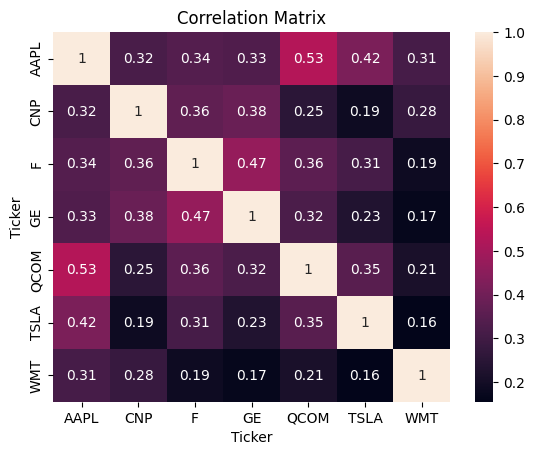

/Users/yawamankwah/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


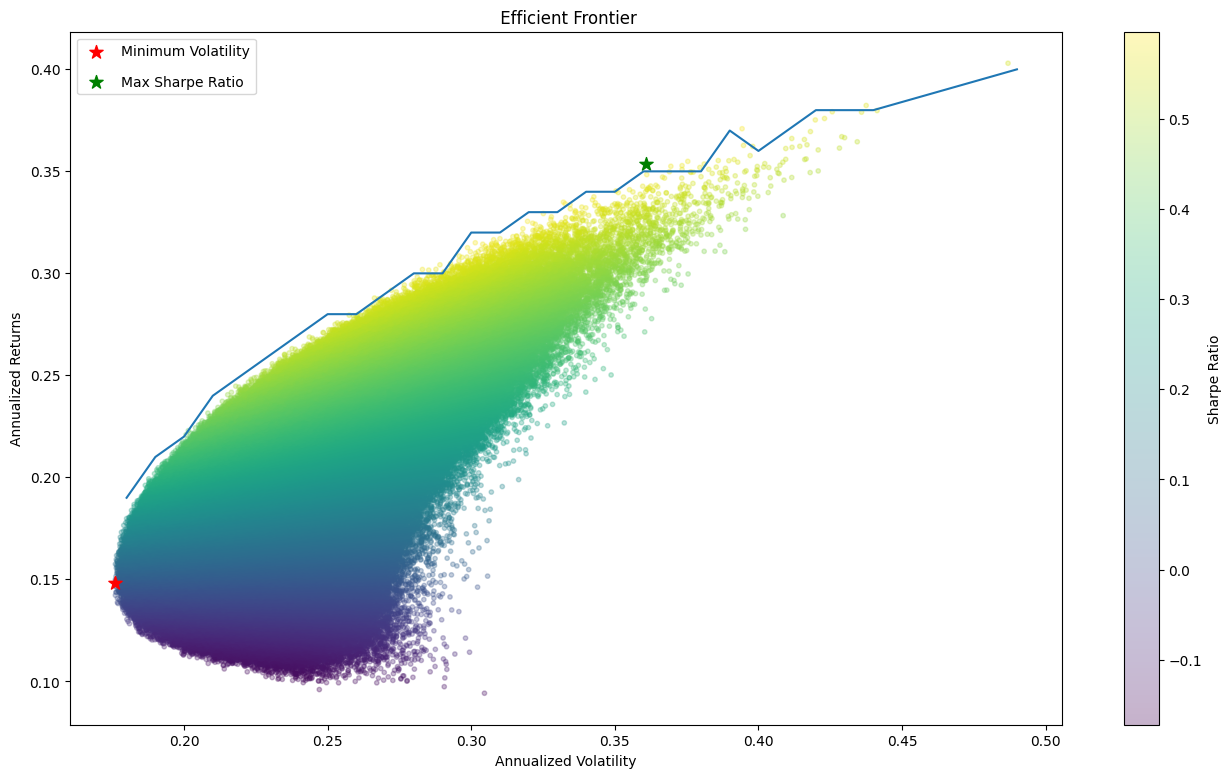

In [158]:
eff_front.output()